# Introduction to Quantum Computing

## Overview 

This notebook provides an introduction to some basic quantum computing concepts and how to program a quantum computer using quantum circuits.

We recommend you have some knowledge of:
* Python programming: language, importing libraries, using functions.
* basic quantum computing concepts: qubits, quantum processes like superposition, interference and entanglement.

### Learning Objects 

After using this notebook you should have an understanding of 

* What are *qubits* and why they are different from classical binary bits.
* What is *superposition* and how it could be used to solve a problem.
* What is *interference & entanglement* and how it could be used to solve a problem.
* What are *quantum circuits* and how they relate to solving a problem. 


In [5]:
# here lets import and set some python/jupyter preliminaries
# you don't need to do much here other than run the cell
%matplotlib inline

# generic plotting library 
import matplotlib
import matplotlib.pyplot as plt
matplotlib.logging.getLogger('matplotlib.font_manager').disabled = True

# penny lane quantum computing library
import pennylane as qml
from pennylane import numpy as np
qml.drawer.use_style('sketch')

# quatnum music visualisation 
import qmuvi
from qiskit import QuantumCircuit

# import interactive widgets
from ipywidgets import interact, interactive, fixed, interact_manual
import ipywidgets as widgets
from IPython.display import display, Markdown, Latex



In [44]:
# some helper function definitions
# again we won't go into the details here but you will need to run the cell

def PlotPennyLaneHisto(results, plottitle : str = ''):
    with plt.xkcd():
    # Based on "Stove Ownership" from XKCD by Randall Munroe
    # https://xkcd.com/418/

        fig = plt.figure()
        ax = fig.add_axes((0.1, 0.2, 0.8, 0.7))
        ax.spines[['top', 'right']].set_visible(False)
        labels = [rf'$|{k}>$' for k in results.keys()]
        xvals = np.arange(len(results.keys()))
        yvals = [results[k] for k in results.keys()]
        ax.bar(labels, yvals, facecolor='DarkOrange', edgecolor='Gold', linewidth=4)
        ax.tick_params(axis='x', labelrotation=80)
        ax.set_xlabel('Qubit States')
        ax.set_ylabel('Count')
        ax.set_title(plottitle)
        fig.show()

def _setupqubits(num_qubits, add_H, hqubits, add_CNOT, cnotqubits):
    qubits = [f'|{i}>' for i in range(1,num_qubits+1)]
    if not add_H:
        hqubits = []
    else:
        if hqubits == 'all':
            hqubits = qubits
        else:
            # parse the hqubit list to ensure that it works
            newhqubits = []
            for q in hqubits:
                if q >=0 and q<num_qubits:
                    newhqubits.append(qubits[q])
            if len(newhqubits)>0:
                hqubits = newhqubits 
            else:
                hqubits = qubits
    if not add_CNOT or len(qubits) == 1:
        cnotqubits = []
    else:
        if cnotqubits == 'default':
            cnotqubits = []
            for q in qubits[1:]:
                cnotqubits.append([qubits[0],q])

    return qubits, hqubits, cnotqubits 

def _reportsim(num_qubits, num_gates, ireport : bool):

    if ireport:
        mem = 2**(num_qubits-30)*(num_gates+1)
        flops = num_gates * 2.0**(num_qubits*5.0)
        display(Markdown('# Simulating Circuit'))
        display(Markdown(f'You have asked to simulate a circuit with {num_qubits} and {num_gates}'))
        display(Markdown(f'* Memory: This would require {mem} GB of memory, or roughly {mem/8} laptops'))
        display(Markdown(f'* Operations: This would require {flops} Floating point operations, or roughly {flops/5e12/128*0.5} seconds on a laptop'))
        
def MakeCircuit(num_qubits : int = 1, 
                add_H : bool = True, 
                add_CNOT : bool = True,
                hqubits : str = 'all',
                cnotqubits : str = 'default', 
                report_system_requirements : bool = False,
               ):
    """
    Construct a circuit with a certain number of qubits
    """
    qubits, hqubits, cnotqubits = _setupqubits(num_qubits, add_H, hqubits, add_CNOT, cnotqubits)
    num_gates = len(hqubits) + len(cnotqubits)
    # circuit     
    dev = qml.device("default.qubit", wires=qubits)
    @qml.qnode(dev)
    def circuit(qubits, hqubits, cnotqubits):
        for q in hqubits:
            qml.Hadamard(wires=q)
        if add_CNOT and len(qubits)>1: 
            for q in cnotqubits:
                qml.CNOT(q)
        return qml.counts(all_outcomes=True)

    _reportsim(num_qubits, num_gates, report_system_requirements)
    # plotting circuit
    fig, ax = qml.draw_mpl(circuit, show_all_wires=True)(qubits, hqubits, cnotqubits)
    fig.show()
    

def MakeAndRunCircuit(num_shots :int = 100, 
                      num_qubits : int = 1, 
                      add_H : bool = True, 
                      add_CNOT : bool = True,
                      hqubits : str = 'all',
                      cnotqubits : str = 'default', 
                      report_system_requirements : bool = False,
                     ):
    """
    Construct a circuit with a certain number of qubits and run a certain number of shots
    """
    max_nshots = 10000
    max_nqubits = 30
    qubits, hqubits, cnotqubits = _setupqubits(num_qubits, add_H, hqubits, add_CNOT, cnotqubits)
    num_gates = len(hqubits) + len(cnotqubits)
    # circuit     
    dev = qml.device("default.qubit", wires=qubits)
    @qml.qnode(dev)
    def circuit(qubits, hqubits, cnotqubits):
        for q in hqubits:
            qml.Hadamard(wires=q)
        if add_CNOT and len(qubits)>1: 
            for q in cnotqubits:
                qml.CNOT(q)
        return qml.counts(all_outcomes=True)

    _reportsim(num_qubits, num_gates, report_system_requirements)
    # plotting circuit
    fig, ax = qml.draw_mpl(circuit, show_all_wires=True)(qubits, hqubits, cnotqubits)
    fig.show()
    if (num_shots > max_nshots) or (num_qubits > max_nqubits):
        display(Markdown('# WARNING'))
        display(Markdown('You have asked to simulate either too many shots (measurements) or too many qubits. ***NOT SIMULATING***'))
        display(Markdown(f'* *Number of measurements should be $<{max_nshots}$ and requested:* {num_shots}'))
        display(Markdown(f'* *Number of qubits should be $<{max_nqubits}$ and requested:* {num_qubits}. This would require {2**(num_qubits-30)} GB of memory and take a long time to simulate'))
    else:
        # now you try running more shots by running the circuit again. 
        results = circuit(qubits, hqubits, cnotqubits, shots=num_shots)
        # here plot the results
        PlotPennyLaneHisto(results, f'Measurment results from {num_shots} measurements')

## Qubits

#### PJE add figure of bit vs qubit

### Classical vs Quantum Bit

* Classical: digital representation of either 0 *or* 1. Fundamental unit of digital information.
* Quantum: often refered to as qubit, fundamental unit of quantum information, analogous to the classical bit. However, here the quantum state holding the information can exist in a *superposition* of states, meaning they can be 0, 1, or ***both 0 and 1 simultaneously***! 

Often you'll see that qubits are written a little differently (using the so-called *braket* or *Dirac* notation). The 0-state is often written as $\ket{0}$ and 1 as $\ket{1}$. A 4-bit qubit, with qubits $q_0, q_1, q_2, q_3$ is $\ket{q_1q_2q_3q_4}$. 

*For more information, see [wikipedia](https://en.wikipedia.org/wiki/Qubit).*

## Quantum Superposition & Measurement
#### PJE add figure of superposition

Superposition is where a qubit can be in both 0 and 1 states at the same time. This mixed state is **NOT** directly measured. Instead measurement of a qubit will return a $\ket{0}$ **or** $\ket{1}$, *not both*.

*How do you know the qubit was in a mixed state before the measurement occurs?* **By repeating the experiment and measurment.** You will see that the qubit will be 0 or 1 with the probability being dependent on the mixed state.

*For more information, see [wikipedia](https://en.wikipedia.org/wiki/Quantum_superposition).*

## Quantum Interference & Entanglement 

#### PJE add figure of entanglement

Quantum entanglement is the a unique feature of quantum mechanics (the physics that governs the small-scale universe) that not present in classical mechanics that well describes our day-to-day world (cars, planes, footballs). The phenomenon is when quantum states are interacting in such a way that the quantum state of each particle of the group cannot be described independently of the state of the others, even when particles are separated by a large distance ("spooky-action-at-a-distance")

### The Qubit perspective 

Let's think about *qubits*. If we have two qubits $\ket{\Psi_1}$ \& $\ket{\Psi_2}$ and a total system state of $\ket{\Psi} = \ket{\Psi_1\Psi_2}$. Now if qubit 1 was in the $\ket{0}$ state and qubit 2 was in $\ket{1}$, then the total system state is written as 
$$
\ket{\Psi} = \ket{\Psi_1\Psi_2} = \ket{01}
$$

If instead these qubits were in both in *equal* superposition then you would have 
$$
\ket{\Psi} = \ket{\Psi_1\Psi_2} = \tfrac{1}{2}\bigl(\ket{00}+ \ket{01}+\ket{10}+\ket{11}\bigr)
$$
and you would get state $\ket{00}$ $25\%$ of the time, $\ket{01}$ $25\%$ of the time and so on, as if you were flipping two independent coins. But what happens if we ***entangle*** these states such that if qubit 2 is linked to the state of qubit 1. You get a $\ket{0}$ for qubit 1, you get a $\ket{0}$ for qubit 2 (that is the coins are linked). In this case we cannot get the states $\ket{01}$ and $\ket{10}$ because the states are entangled. 

Now consider these qubits if they are qubit 1 was in *equal* superposition, and qubit 2 is in $\ket{0}$, then you couldn't get $\ket{11}$. But because of the entanglement, the total state of the system, $\ket{\Psi}$ is 
$$
\ket{\Psi} = \ket{\Psi_1\Psi_2} = c\bigl(\ket{00}+\ket{11}\bigr)
$$

*For more information, see [wikipedia](https://en.wikipedia.org/wiki/Quantum_entanglement).*

## Quantum Circuits

Quantum programs (or algorithms) are often visualised as a *quantum circuit* as shown below. 

![3 Qubit Circuit](simple_circuit_annotated_small.png "3 Qubit circuit")

This shows the evolution of qubits as a single line going from left to right. If you ever see a doubled lines that represent a classical bit. Quantum gates are shows as symbols on the line and the entire program is this sequence of operations on qubits.  These lines define the sequence of events, and are usually not physical cables. 

This is a nice way fo visualising a quantum program as it can show what happens to a given qubit and also which qubits are interacting (as shown by vertical lines with symbols ending on the qubit lines). 

## Simulating Quantum Computers and running Quantum Circuits

There are a variety of tools out there which can simulate a quantum computer (albeit slowly and only for small qubit counts). In this notebook, we'll make use of a few of them, namely [**PennyLane**](https://pennylane.ai/) and [**Qiskit**](https://www.ibm.com/quantum/qiskit). We'll also use some nice tools like [**qmuvi**](https://github.com/garymooney/qmuvi) a visualisation tool and [**matplotlib**](https://matplotlib.org/)

### PennyLane
PennyLane is a cross-platform Python library for quantum computing, quantum machine learning, and quantum chemistry. We won't make use of all the functionality but the basics is that you can make use of a quantum computer simulator by invoking a device. 

```python
import pennylane as qml
# here `wires
qml.device('default.qubit', wires=number_of_qubits)
```

You'll note some funny terminology such as `pennylane` often invoked as `qml` and `wires` being the number of qubits. Then to construct a circuit you need to define a function that places gates (operations) on the qubits in the circuit.

```python
# let's define a 2-qubit circuit that has some gates (to be discussed later)
def circuit():
    qml.NOT(wires=0)
    qml.Hadamard(wires=1)
    qml.CNOT([1,0])
    return qml.counts(all_outcomes=True)

```

We'll make use of these basic idea's later. 

### Qiskit
Qiskit is another library for quantum computing. Like PennyLane it has lots of nice functionality for simulating and working with quantum circuits.

```python
from qiskit import QuantumCircuit
from qiskit.quantum_info import SparsePauliOp
from qiskit.transpiler.preset_passmanagers import generate_preset_pass_manager
from qiskit_ibm_runtime import EstimatorV2 as Estimator
 
# Create a new circuit with two qubits
qc = QuantumCircuit(2)
# Add a NOT gate on qubit 1
qc.x(0)
# Add a Hadamard gate to qubit 1
qc.h(1)
# Perform a controlled-X gate on qubit 1, controlled by qubit 0
qc.cx(0, 1)
```

## Superposition or Hadamard Gate

One of the simplest instructions or operations you can apply to a qubit is the *Hadamard* gate, $H$, which essentially implements **superposition**, turning a state of $\ket{0}$ or $\ket{1}$ into an equal superposition of $\ket{0}$ and $\ket{1}$. More precisely 
$$H\ket{0} = \frac{\ket{0}+\ket{1}}{\sqrt{2}}, \quad H\ket{1} = \frac{\ket{0}-\ket{1}}{\sqrt{2}}$$

In both cases, one changes the qubit from just return it's initial state when being measured to giving either 0 or 1 with $50\%$ probability. 

Let's consider a quantum circuit consisting of a single qubit starting in $\ket{0}$ and applying a Hadarmard gate. 

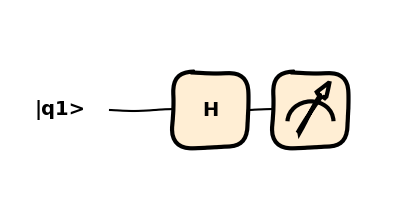

In [7]:
# sample code to draw a hadarmad gate using PennyLane
# here 
dev = qml.device("default.qubit", wires=["|q1>"])

# now simple circiut where we return the state of the qubits
@qml.qnode(dev)
def circuit():
    qml.Hadamard(wires="|q1>")
    return qml.counts(all_outcomes=True)

# plot the circuit
fig, ax = qml.draw_mpl(circuit)()

What could we expect if we measured the output of this circuit 10 times? 100 times? What happens if you do 1000 times?

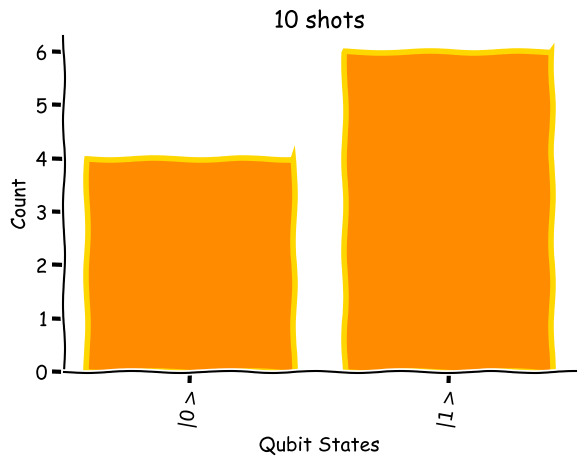

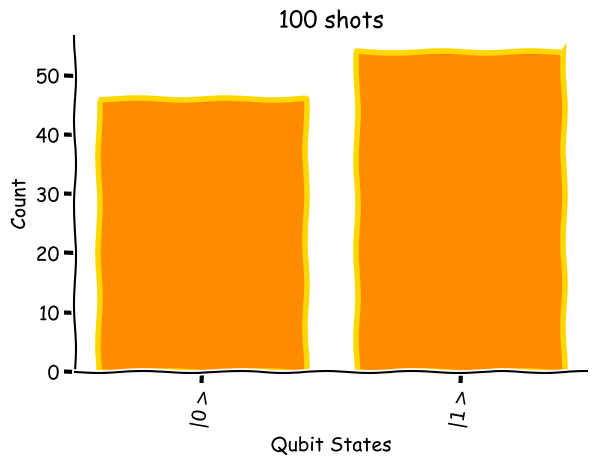

In [8]:
# lets create a quantum device that will take 10 shots
results = circuit(shots=10)
# here plot the results
PlotPennyLaneHisto(results, '10 shots')

# now you try running more shots by running the circuit again. 
results = circuit(shots=100)
# here plot the results
PlotPennyLaneHisto(results, '100 shots')

# what would you expect if you could infinitly sample the simple circuit?


### What's the "sound" of a mixed state?

To gain more understainding, let's look at using the **qmuvi** visualisation tool to see what is happening with the Hadamard gate. In a classical system, you can only have 0 or 1 but in the quantum system, while the state is not measured, it is a real mixture of 0 and 1. Let's consider a musical analogue. If we considered 0 to be a note and 1 being another then we should expect the music to start with a single note before the Hadamard gate is placed, then it should become two notes and when measured go back to one of the notes. 

Here we'll have to use Qiskit to create the circuit 

In [9]:
# c
circuit = QuantumCircuit(1)
# Barrier gates tell qMuVi where to sample the state in the circuit. It's like you are measuring the system with out truly collapsing the state
circuit.barrier()
circuit.h(0)
circuit.barrier()
# how to measure with qiskit that works with qmuvi?
#circuit.

qmuvi.generate_qmuvi(circuit, "hadamard")

Generating qMuVi data...
Generating MIDI track files...
Converting to .wav files using TiMidity++
Errors in thread 0:


CalledProcessError: Command '['/Users/ela017/software/pyvenv/lib/python3.9/site-packages/qmuvi/package_data/binaries/TiMidity-2.15.0/macos/timidity', '-Ow', '--preserve-silence', '-A,120', '--no-anti-alias', '--mod-wheel', '--portamento', '--vibrato', '--no-ch-pressure', '--mod-envelope', '--trace-text-meta', '--overlap-voice', '--default-bank=0', '--default-program=0', '--delay=d,0', '--chorus=n,64', '--reverb=f,40,0.28,0.7,100', '--voice-lpf=c', '--noise-shaping=4', '--resample=5', '--voice-queue=0', '--decay-time=0', '--interpolation=gauss', '-EFresamp=34', '--output-stereo', '--output-24bit', '--polyphony=15887', '--sampling-freq=44100', '--volume-curve=1.661', '--config-file="/Users/ela017/software/pyvenv/lib/python3.9/site-packages/qmuvi/package_data/resources/timidity/timidity.cfg"', '-o', '"/Users/ela017/myresearch/quantumcomputing/quantum-computing-hackathon/lessons/hadamard-output-6/hadamard-4.wav"', '"/Users/ela017/myresearch/quantumcomputing/quantum-computing-hackathon/lessons/hadamard-output-6/hadamard-4.mid"']' returned non-zero exit status 1.

### Playing with Hadamard's 

#### Interactive widget
We can make use of an interactive tool to create and run some plots. Lets try just visualising some circuits. Then we'll try running a simulation of a quantum circuit. Try running more than one qubit or more than one gate per qubit. What do you see?

#### Custom
If you really interested, look at the boiler plate code in the section below and try playing with it. 


In [46]:
# here's an interactive widget 
hqubits = []
interact(MakeCircuit, num_qubits=widgets.IntSlider(min=1, max=100, step=1, value=2), 
         add_H=True, 
         add_CNOT = fixed(False), 
         hqubits=fixed('all'),
         cnotqubits = fixed('default')
        )

interactive(children=(IntSlider(value=2, description='num_qubits', min=1), Checkbox(value=True, description='a…

<function __main__.MakeCircuit(num_qubits: int = 1, add_H: bool = True, add_CNOT: bool = True, hqubits: str = 'all', cnotqubits: str = 'default', report_system_requirements: bool = False)>

You can even try simulating the output of a quantum computer

In [48]:
interact(MakeAndRunCircuit, 
         num_shots=widgets.IntSlider(min=10, max=10000, step=5, value=10), 
         num_qubits=widgets.IntSlider(min=1, max=10, step=1, value=2), 
         add_H=True, 
         add_CNOT = fixed(False), 
         hqubits=fixed('all'))

interactive(children=(IntSlider(value=10, description='num_shots', max=10000, min=10, step=5), IntSlider(value…

<function __main__.MakeAndRunCircuit(num_shots: int = 100, num_qubits: int = 1, add_H: bool = True, add_CNOT: bool = True, hqubits: str = 'all', cnotqubits: str = 'default', report_system_requirements: bool = False)>

In [30]:
# Here is the boiler plate
# you can list the qubits and pass wires

# initialise a device with lets say some number of qubits (which you can directly pass to wires)
num_qubits = 
dev = qml.device("default.qubit", wires=num_qubits)
@qml.qnode(dev)
def circuit():
    # add your circuits here
    # for example to add a hadamard gate to the first qubit 
    # qml.Hadamard(wires=0)
    # what happens if you apply two hadamard gates to a single qubit?
    
    return qml.counts(all_outcomes=True)

# lets look at the circuit
fig, ax = qml.draw_mpl(circuit)()

# then run the circuit and plot the result. How many shots do you think you need to take to really get the ideal (true) result?
num_shots = 
results = circuit(shots=num_shots)
PlotPennyLaneHisto(results, f' {num_shots} shots')


SyntaxError: invalid syntax (2848303606.py, line 5)

## Entanglement or "CNOT" Gate

Another of the simplest instructions or operations you can apply to two qubits is the *Controlled NOT (CNOT)* gate, $CNOT(\textrm{qubit}_{1}, \textrm{qubit}_{2})$ which essentially implements entanglement. It entangles two qubits so that the state of the second qubit is dependent on the state of the first. The CNOT gate flips the second qubit (the target qubit) if and only if the first qubit (the control qubit) is $\ket{1}$. So if we look at table of what happens before and after entanglement we see 

| Before       |              | | After        |              |
| ------------ | ------------ | - | ------------ | ------------ |
| Control $\ket{q_1}$ | Target $\ket{q_2}$  | $\rightarrow$ | Control $\ket{q_1}$  | Target $\ket{q_2}$  |
| $\ket{0}$    | $\ket{0}$    | $\rightarrow$ | $\ket{0}$    | $\ket{0}$    |
| $\ket{1}$    | $\ket{0}$    | $\rightarrow$ |  $\ket{1}$    | $\ket{1}$    |
| $\ket{0}$    | $\ket{1}$    | $\rightarrow$ |  $\ket{0}$    | $\ket{1}$    |
| $\ket{1}$    | $\ket{1}$    | $\rightarrow$ |  $\ket{1}$    | $\ket{0}$    |


You can view this as an a classical computers *if* statement, where you change something based on a condition, though here it is important to remember that you don't know what the outcome is till you measure the qubits. These entangled two-qubit states are sometimes referred to as *Bell* states. 

In [ ]:
# sample code to draw a CNOT gate using PennyLane
# here 
dev = qml.device("default.qubit", wires=["|q1>", "|q2>"])

# now simple circiut where we return the state of the qubits
@qml.qnode(dev)
def circuit():
    # CNOT takes a list of two qubits with the first being the control and the second being the qubit being entangled.  
    qml.CNOT(["|q1>","|q2>"])
    return qml.counts(all_outcomes=True)

# plot the circuit
fig, ax = qml.draw_mpl(circuit, show_all_wires=True)()

Now this CNOT gate is not exceptionally useful on its own but combined with superposition, it can be very useful. Let's consider the following circuits where the first qubit is in superposition:

In [ ]:
# sample code to draw a CNOT gate using PennyLane
dev = qml.device("default.qubit", wires=["|q1>", "|q2>"])

# now simple circiut where we return the state of the qubits
@qml.qnode(dev)
def circuit():
    qml.Hadamard(wires="|q1>")
    qml.CNOT(["|q1>","|q2>"])
    return qml.counts(all_outcomes=True)

@qml.qnode(dev)
def circuitnoCNOT():
    qml.Hadamard(wires="|q1>")
    return qml.counts(all_outcomes=True)

# plot the circuit
fig, ax = qml.draw_mpl(circuitnoCNOT, show_all_wires=True)()
fig, ax = qml.draw_mpl(circuit, show_all_wires=True)()


In [ ]:
# lets create the quantum device and run the noCNOT circuit
dev = qml.device("default.qubit", wires=["|q1>", "|q2>"])

@qml.qnode(dev)
def circuitnoCNOT():
    qml.Hadamard(wires="|q1>")
    return qml.counts(all_outcomes=True)
results = circuitnoCNOT(shots=100)
# here plot the results
PlotPennyLaneHisto(results, '100 shots, no CNOT')

Here, we see that we get either $\ket{00}$ or $\ket{10}$ with equal probability. What do you expect to see if you have a CNOT? (discuss then try uncommenting the results)

In [ ]:
# now do the same with CNOT
dev = qml.device("default.qubit", wires=["|q1>", "|q2>"])

# now simple circiut where we return the state of the qubits
@qml.qnode(dev)
def circuit():
    qml.Hadamard(wires="|q1>")
    qml.CNOT(["|q1>","|q2>"])
    return qml.counts(all_outcomes=True)

results = circuit(shots=100)
# here plot the results
# PlotPennyLaneHisto(results, '100 shots, apply CNOT')

### Playing with CNOT's 

Let the Hadarmard gates, let's try a simple interactive setup. 

If you are really interested, you can try playing with the boiler plate code as well. 
Try playing with this gate with the boiler plate code below. Try running more than two qubits and entangling lot of them. What do you see

In [49]:
# note here that I've added a hadamard to the first qubit
# consider trying to play with this
hadamard_set = [0]
interact(MakeAndRunCircuit, 
         num_shots=widgets.IntSlider(min=10, max=10000, step=5, value=10), 
         num_qubits=widgets.IntSlider(min=1, max=10, step=1, value=2), 
         add_H=fixed(True), 
         add_CNOT = fixed(True), 
         hqubits=fixed(hadamard_set))

interactive(children=(IntSlider(value=10, description='num_shots', max=10000, min=10, step=5), IntSlider(value…

<function __main__.MakeAndRunCircuit(num_shots: int = 100, num_qubits: int = 1, add_H: bool = True, add_CNOT: bool = True, hqubits: str = 'all', cnotqubits: str = 'default', report_system_requirements: bool = False)>

In [31]:
# now boiler plate code for CNOT
dev = qml.device("default.qubit", wires=["|q1>", "|q2>", "|q3>",])

# now simple circiut where we return the state of the qubits
@qml.qnode(dev)
def circuit():
    qml.Hadamard(wires="|q1>")
    qml.CNOT(["|q1>","|q2>"])
    return qml.counts(all_outcomes=True)
# what does your circuit look like 
# fig, ax = qml.draw_mpl(circuit, show_all_wires=True)()

# lets create a quantum device that will take 100 shots
results = circuit(shots=100)
# here plot the results
# PlotPennyLaneHisto(results, 'Your experiment')

## References

* Some reference